In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import collections
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.image as mpimg
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import gc

### Draw Keypoints for a given image and detector.


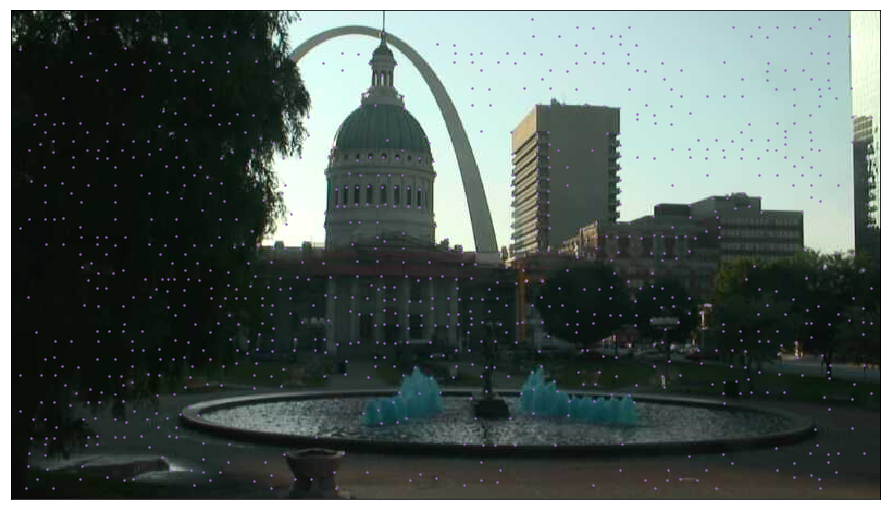

In [129]:
############################
### FUNCTIONS
############################
def nn_match_two_way(kpts1, kpts2, dist):
    """
    Performs two-way nearest neighbor matching of two sets of keypoints, such
    that the match from keypoints A->B must equal the match from B->A.

    Inputs:
      kpts1 - NxM numpy matrix of N corresponding M-dimensional keypoints.
      kpts2 - NxM numpy matrix of N corresponding M-dimensional keypoints.
      dist - Distance in pixels below that two keypoints are considered a match.

    Returns:
      matches - Lx4 numpy array, of L matches, where L <= N and each column i is
                a match of two keypoints, d_i in image 1 and d_j' in image 2:
                [d_i index, d_j' index, l2 distance, accurcy]
    """
    # Check if descriptor dimensions match
    assert kpts1.shape[1] == kpts2.shape[1]

    # Return zero matches, if one image does not have a keypoint and
    # therefore no descriptors.
    if kpts1.shape[0] == 0 or kpts2.shape[0] == 0:
        return np.zeros((0, 4))
    if dist <= 0.0:
        raise ValueError('\'nn_thresh\' should greater zero')

    # Compute L2 distance. Easy since vectors are unit normalized.
    dmat = np.linalg.norm(kpts2-kpts1[:, np.newaxis], axis=2)

    # Get NN indices and scores.
    idx = np.argmin(dmat, axis=1)
    scores = dmat[np.arange(dmat.shape[0]), idx]
    
    # Threshold the NN matches.
    keep = scores < dist
   
    # Check if nearest neighbor goes both directions and keep those.
    idx2 = np.argmin(dmat, axis=0)
    keep_bi = np.arange(len(idx)) == idx2[idx]
    keep = np.logical_and(keep, keep_bi)
    idx = idx[keep]
    scores = scores[keep]
   
    # Get the surviving point indices.
    m_idx1 = np.arange(kpts1.shape[0])[keep]
    m_idx2 = idx
    
    # Populate the final Nx3 match data structure.
    matches = np.zeros((int(keep.sum()), 4))
    matches[:, 0] = m_idx1
    matches[:, 1] = m_idx2
    matches[:, 2] = scores
    matches[:, 3] = 1.0 - (scores / dist)
    return matches

def load_keypoints(kp_file_path:str, kp_thresh:int=10000) -> np.array:
    return pd.read_csv(kp_file_path, 
                   sep=',', comment='#', header=None, usecols=[0, 1]).values[:kp_thresh]

def draw_keypoints(ax, kpts:np.array, detector_name:str, color_scheme:Dict, mpl_kw:Dict={}):
    
    color = mpl_kw.pop('color', None)
    if color is None:
        color = color_scheme[detector_name]
        
    
    ax.scatter(kpts[:, 0], kpts[:, 1],
              color=color,
              marker='o',
              s=2,
              **mpl_kw)
    
    return ax

def get_set_names(data_dir:str, sort_output:bool=True) -> List[str]:
    set_names = [x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))]

    if sort_output:
        set_names = sorted(set_names)
    
    return set_names

def get_file_names_in_set(path_set:str, file_scheme:str, sort_output:bool=True) -> List[str]:
    file_names = [x for x in os.listdir(path_set) if os.path.isfile(os.path.join(path_set, x))]
 
    # get the correct files with fitting file scheme.
    file_names = [x for x in file_names if file_scheme in x]

    if sort_output:
        file_names = sorted(file_names)

    return file_names

############################
### SETTINGS
############################

id2name = {
    'sift': 'SIFT',
    'lift': 'LIFT',
    'tilde': 'TILDE',
    'superpoint': 'SuperPoint',
    'tcovdet': 'TCovDet',
    'tfeat': 'TFeat',
    'doap': 'DOAP',
    'chamonix': 'Chamonix', 
    'courbevoie': 'Courbevoie', 
    'frankfurt': 'Frankfurt',
    'mexico': 'Mexico',
    'panorama': 'Panorama', 
    'stlouis': 'St. Louis'
}

color_scheme = {
  'sift': '#1f77b4',
  'lift': '#ff7f0e',
  'tilde': '#2ca02c',
  'superpoint': '#d62728',
  'tcovdet': '#9467bd',
  'tfeat': '#2ca02c',
  'doap': '#9467bd'
}

keypoint_threshold_colors = ['skyblue', 'crimson', 'purple']

marker_scheme = {
  'sift': 'o',
  'lift': 'x',
  'tilde': 'd',
  'superpoint': '^',
  'tcovdet': 'h',
  'tfeat': '*',
  'doap': 'p'
}

line_styles = ['-', '-.', ':', '--']


collection_name = 'webcam'
file_scheme = '_10000.csv'

image_dir = '/home/mizzade/Workspace/diplom/code/data'
data_dir = '/home/mizzade/Workspace/diplom/outputs'
output_dir = '/home/mizzade/Workspace/diplom/outputs/eval_detectors/images'
file_name = 'repeatability_webcam.csv'

path_collection_img = os.path.join(image_dir, collection_name)
path_collection_kp = os.path.join(data_dir, collection_name)


set_names = get_set_names(path_collection_img, sort_output=True)



############################
### MAIN
############################


detector_names = ['sift', 'lift', 'tcovdet' , 'tilde', 'superpoint']
keypoint_thresholds = [1000, 5000, 10000]
dist_error_thresholds = [3] # in pixels

# Get image files in set.
set_name = 'stlouis'
detector_name = 'superpoint'
kp_thresh = keypoint_thresholds[0]
image_number = 0

set_path_img = os.path.join(path_collection_img, set_name)
set_path_kp = os.path.join(path_collection_kp, set_name, 'keypoints', detector_name)

image_files = get_file_names_in_set(set_path_img, '.png')
kp_files = get_file_names_in_set(set_path_kp, file_scheme)

# Load image
img = mpimg.imread(os.path.join(set_path_img, image_files[image_number]))

# Scalefactor for tcovdet
_h, _w = img.shape[:2]
tcovdet_sf = 1.0
if (_h * _w) > 1024*768:
    tcovdet_sf =  (1024 * 768 / float(_h * _w))**(0.5)


plt.rcParams['figure.figsize'] = [16, 9]
fig, ax = plt.subplots(1, 1)
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(img)

kpts_lit = []
for detector_name in detector_names[2:3]:
    # Load keypoints
    kpts_file_path = os.path.join(set_path_kp, kp_files[image_number])
    kpts = load_keypoints(kpts_file_path, kp_thresh)
    if detector_name == 'tcovdet':
        kpts *= tcovdet_sf
    
    # Draw them
    ax = draw_keypoints(ax, kpts, detector_name, color_scheme)


Zeige wiederholbare Keypoints in zwei Bildern für einen ausgewählten Detektor, 1000 Keypoints

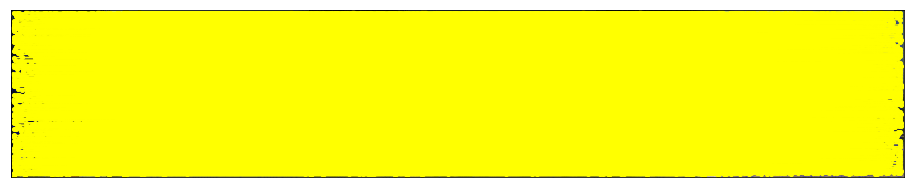

In [308]:
draw_repeatable_kp_for_three_images(
    'sift',
    set_path_kp,
    set_path_img,
    color_scheme,
    image_numbers=[1, 2, 4],
    kp_thresh= 1000,
    num_rep_kp=None,
    seed=42)

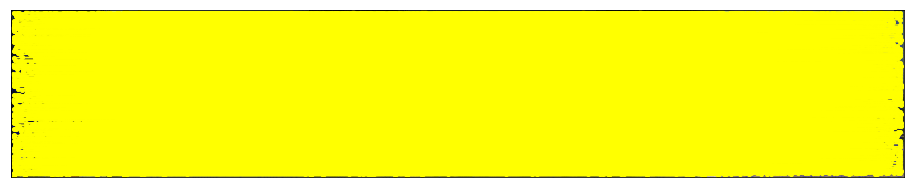

In [309]:
draw_repeatable_kp_for_three_images(
    'superpoint',
    set_path_kp,
    set_path_img,
    color_scheme,
    image_numbers=[1, 2, 4],
    kp_thresh= 1000,
    num_rep_kp=None,
    seed=42)

In [305]:
def draw_repeatable_kp_for_three_images(
    detector_name:str,
    set_path_kp:str,
    set_path_img:str,
    color_scheme:Dict,
    image_numbers:Tuple[int, int, int] = [1, 2, 3],
    kp_thresh:int=1000,
    num_rep_kp:int=None,
    seed:int=0):

    # Load images, stack them, compute x-axis offset for kpts from image2
    img1 = mpimg.imread(os.path.join(set_path_img, image_files[image_numbers[0]]))
    img2 = mpimg.imread(os.path.join(set_path_img, image_files[image_numbers[1]]))
    img3 = mpimg.imread(os.path.join(set_path_img, image_files[image_numbers[2]]))
    img = np.hstack([img1, img2, img3])

    offset1 = np.array([img1.shape[1], 0])
    offset2 = offset1 + np.array([img2.shape[1], 0])

    # Load keypoints
    kp_path1 = os.path.join(set_path_kp, kp_files[image_numbers[0]])
    kp_path2 = os.path.join(set_path_kp, kp_files[image_numbers[1]])
    kp_path3 = os.path.join(set_path_kp, kp_files[image_numbers[2]])

    kp1 = load_keypoints(kp_path1, kp_thresh)
    kp2 = load_keypoints(kp_path2, kp_thresh)
    kp3 = load_keypoints(kp_path3, kp_thresh)

    # Compute repeatable keypoints for (img1,img2) and (img2, img3)
    matches1 = nn_match_two_way(kp1, kp2, 3)[:, :2].astype(np.int)
    matches2 = nn_match_two_way(kp2, kp3, 3)[:, :2].astype(np.int)

    # Find indices of kp2, that are in matches1 AND matches2
    idx1 = matches1[:, 0].astype(np.int)
    idx2 = matches1[:, 1].astype(np.int)

    idx3 = matches2[:, 0].astype(np.int)
    idx4 = matches2[:, 1].astype(np.int)


    # Draw keypoints to corresponding images
    plt.rcParams['figure.figsize'] = [16, 9]
    fig, ax = plt.subplots(1, 1)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(img)

    # First: Draw all keypoints
    draw_keypoints(ax, kp1, detector_name, color_scheme, {'alpha': 0.2, 'color': 'b'})
    draw_keypoints(ax, kp2 + offset1, detector_name, color_scheme, {'alpha': 0.2, 'color': 'b'})
    draw_keypoints(ax, kp3 + offset2, detector_name, color_scheme, {'alpha': 0.2, 'color': 'b'})

    # Second: Draw only the repeatable ones.
    draw_keypoints(ax, _kp1, detector_name, color_scheme, {'alpha': 1, 'color': 'r'})
    draw_keypoints(ax, _kp2, detector_name, color_scheme, {'alpha': 1, 'color': 'r'})
    draw_keypoints(ax, _kp3, detector_name, color_scheme, {'alpha': 1, 'color': 'r'})

    # 1. Find out which keypoitns of image2 have been matched in image1 AND image2
    intersect = np.intersect1d(idx2, idx3)

    rng = np.random.RandomState(seed=seed)
    idx_i = np.arange(len(intersect))
    
    if num_rep_kp is None or num_rep_kp > len(intersect):
        num_rep_kp = len(intersect)

    # # draw `num_rep_kp` random indices from intesect
    sub = rng.choice(idx_i, num_rep_kp, replace=False)

    for j in intersect[sub]:
        m1 = np.where(idx2 == j)[0][0]

        # Do the same for matches 2:
        m2 = np.where(idx3 == j)[0][0]


        # Get coodrinates
        k1 = kp1[matches1[m1][0]]
        k2 = kp2[matches1[m1][1]] + offset1
        k3 = kp3[matches2[m2][1]] + offset2

        # stack
        pos = np.vstack([k1, k2, k3])
        ax.plot(pos[:, 0], pos[:, 1], color='yellow')
        ax.scatter(pos[:, 0], pos[:, 1], color='yellow', marker='o', s=17)


    



In [187]:
c = np.arange(10).reshape(-1, 2)
np.where(c[:, 0] == 4)[0][0]

2